# Part 3. Enhancement
The RNN model used in Part 2 is a basic model to perform the task of sentiment classification. In
this section, you will design strategies to improve upon the previous model you have built. You are
required to implement the following adjustments:

1. Instead of keeping the word embeddings fixed, now update the word embeddings (the same
way as model parameters) during the training process.
2. As discussed in Question 1(c), apply your solution in mitigating the influence of OOV words
and train your model again.
3. Keeping the above two adjustments, replace your simple RNN model in Part 2 with a biLSTM model and a biGRU model, incorporating recurrent computations in both directions and
stacking multiple layers if possible.
4. Keeping the above two adjustments, replace your simple RNN model in Part 2 with a Convolutional Neural Network (CNN) to produce sentence representations and perform sentiment
classification.
5. Further improve your model. You are free to use any strategy other than the above mentioned solutions. Changing hyper-parameters or stacking more layers is not counted towards
a meaningful improvement.


In [109]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from datasets import load_dataset
import numpy as np
import json
import nltk
from gensim.models import FastText
from common_utils import EmbeddingMatrix, CustomDatasetPreparer, set_seed
import collections
import torch.nn.utils as nn_utils
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="torch")

set_seed()

In [3]:
word_embeddings = EmbeddingMatrix.load()
word_embeddings.add_padding()
word_embeddings.add_unk_token()

### CNN Single Channel

In [132]:
# Reference: https://d2l.ai/chapter_natural-language-processing-applications/sentiment-analysis-cnn.html
class CNN(nn.Module):
    def __init__(self, word_embeddings, embedding_dim, num_classes, num_filters, filter_sizes, dropout):
        super(CNN, self).__init__()
        # Create input layer, for the pretrained embedding matrix
        self.embedding = nn.Embedding.from_pretrained(word_embeddings.to_tensor, freeze=False)

        # Enable back propagation -> Part 3 Task 1, allowing embeddings to be updated
        self.embedding.weight.requires_grad = True 

        # To store a list of Convolutions Layers, for 2-gram, 3-gram, 4-gram, 5-gram, 6-gram models.
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=fs) for fs in filter_sizes # fs = N-gram for varying length
        ])

        # Output the final result => Classes, 2 for our binary classification case
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)

        # Randomly drops some elements in the input tensor as a form of Regulatization, to prevent overfitting
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # Shape: (batch_size, sequence_length, embedding_dim)
        x = self.dropout(self.embedding(x))

        # Reshape to (batch_size, embedding_dim, sequence_length), as per Conv1d's expectation
        x = x.permute(0, 2, 1)

        # Applying ReLU activation function for each N-gram Conv1d layer
        conv_results = [F.relu(conv(x)) for conv in self.convs]

        # To perform max-over-time-pooling, taking the max value across entire sequence length for each filter, reducing the dimentionality of the output
        # Maybe can consider avg_pool1d too
        pool_results = [conv.max(dim=-1).values for conv in conv_results]
        
        # Concatenate the pooled features
        x = self.dropout(torch.cat(pool_results, dim=-1))

        prediction = self.fc(x)
        
        return prediction

In [ ]:
BATCH_SIZE = 64
NUM_FILTERS = 100 
FILTER_SIZES = [2, 3, 4, 5, 6, 7] # Essentially treating single CNN 1 Dimensional as N-gram model (Use the filter size to determine computation with kernel)
DROPOUT = 0.5
EPOCHS = 5
NUM_CLASSES = 2 
EMBEDDING_DIM = 100  
VOCAB_SIZE = word_embeddings.vocab_size
LEARNING_RATE = 0.001

dataset_preparer = CustomDatasetPreparer(
    dataset_name="rotten_tomatoes",
    batch_size=BATCH_SIZE
)

train_loader, val_loader, test_loader = dataset_preparer.get_dataloaders()

In [ ]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def train(train_loader, model, criterion, optimizer):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in train_loader:
        inputs, extra_features, lengths, labels = batch
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        accuracy = get_accuracy(outputs, labels)
        optimizer.zero_grad()
        loss.backward()

        nn_utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        
        optimizer.step()

        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

def evaluate(data_loader, model, criterion):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    
    with torch.no_grad():
        for batch in data_loader:
            inputs, extra_features, lengths, labels = batch
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            accuracy = get_accuracy(outputs, labels)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

def eval_pipeline(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Idea: Can use Adam / MiniAdam / SGD with Momentum
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

    n_epochs = 10
    best_valid_loss = float("inf")
    patience = 3
    epochs_no_improve = 0
    metrics = collections.defaultdict(list)

    for epoch in range(n_epochs):
        train_loss, train_acc = train(train_loader, model, criterion, optimizer)
        valid_loss, valid_acc = evaluate(val_loader, model, criterion)
        metrics["train_losses"].append(train_loss)
        metrics["train_accs"].append(train_acc)
        metrics["valid_losses"].append(valid_loss)
        metrics["valid_accs"].append(valid_acc)

        scheduler.step()

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            epochs_no_improve = 0  
            torch.save(model.state_dict(), 'result/best_cnn.pt')
        else:
            epochs_no_improve += 1 
        if epochs_no_improve == patience:
            print("Early stopping triggered")
            break
        print(f"epoch: {epoch}")
        print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}, valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

    model.load_state_dict(torch.load('result/best_cnn.pt', weights_only=True))
    test_loss, test_accuracy = evaluate(test_loader, model, criterion)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


In [133]:
model = CNN(word_embeddings, EMBEDDING_DIM, NUM_CLASSES, NUM_FILTERS, FILTER_SIZES, DROPOUT)
eval_pipeline(model)

epoch: 0
train_loss: 0.665, train_acc: 0.610, valid_loss: 0.576, valid_acc: 0.728
epoch: 1
train_loss: 0.564, train_acc: 0.707, valid_loss: 0.525, valid_acc: 0.751
epoch: 2
train_loss: 0.506, train_acc: 0.749, valid_loss: 0.493, valid_acc: 0.764
epoch: 3
train_loss: 0.439, train_acc: 0.796, valid_loss: 0.489, valid_acc: 0.772
epoch: 4
train_loss: 0.402, train_acc: 0.815, valid_loss: 0.473, valid_acc: 0.776
epoch: 5
train_loss: 0.369, train_acc: 0.839, valid_loss: 0.472, valid_acc: 0.783
epoch: 6
train_loss: 0.315, train_acc: 0.863, valid_loss: 0.476, valid_acc: 0.782
epoch: 7
train_loss: 0.293, train_acc: 0.872, valid_loss: 0.490, valid_acc: 0.776
Early stopping triggered
Test Loss: 0.4444, Test Accuracy: 0.7805


### Hyperparameters Tuning

In [30]:
import optuna
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="optuna.distributions")

def objective(trial):
    filter_sizes = trial.suggest_categorical('filter_sizes', [[2, 3, 4, 5, 6, 7], [3, 4, 5, 6, 7, 8]])
    num_filters = trial.suggest_int('num_filters', 50, 200)
    dropout = trial.suggest_float('dropout', 0.3, 0.7)
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-2)
    num_epochs = trial.suggest_int('num_epochs', 5, 8)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    
    model = CNN(word_embeddings, EMBEDDING_DIM, NUM_CLASSES, num_filters, filter_sizes, dropout)
    
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    best_valid_loss = float('inf')

    for epoch in range(num_epochs):
        train_loss, train_acc = train(train_loader, model, criterion, optimizer)
        valid_loss, valid_acc = evaluate(val_loader, model, criterion)
        scheduler.step()

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
    
    return best_valid_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=3)

print("Best hyperparameters:", study.best_params)


[I 2024-11-06 14:56:42,956] A new study created in memory with name: no-name-651ce70d-d02d-4c9a-b0f6-24400a706f3a
[I 2024-11-06 14:57:32,731] Trial 0 finished with value: 0.48370371846591725 and parameters: {'filter_sizes': [2, 3, 4, 5, 6, 7], 'num_filters': 114, 'dropout': 0.3113481098776888, 'learning_rate': 0.0021187974789979103, 'num_epochs': 7, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.48370371846591725.
[I 2024-11-06 14:58:11,850] Trial 1 finished with value: 0.5218492343145258 and parameters: {'filter_sizes': [2, 3, 4, 5, 6, 7], 'num_filters': 132, 'dropout': 0.3817055765972406, 'learning_rate': 0.008435386959992727, 'num_epochs': 5, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.48370371846591725.
[I 2024-11-06 14:59:16,784] Trial 2 finished with value: 0.6778740497196422 and parameters: {'filter_sizes': [2, 3, 4, 5, 6, 7], 'num_filters': 158, 'dropout': 0.674489889235476, 'learning_rate': 0.004148274286966717, 'num_epochs': 8, 'optimizer': 'SGD'}. Best is trial 

Best hyperparameters: {'filter_sizes': [2, 3, 4, 5, 6, 7], 'num_filters': 114, 'dropout': 0.3113481098776888, 'learning_rate': 0.0021187974789979103, 'num_epochs': 7, 'optimizer': 'Adam'}


In [32]:
EPOCHS = 2
NUM_FILTERS = 114
FILTER_SIZES = [2, 3, 4, 5, 6, 7] # Essentially treating single CNN 1 Dimensional as N-gram model (Use the filter size to determine computation with kernel)
DROPOUT = 0.3113481098776888
LEARNING_RATE = 0.002118797478997910
NUM_CLASSES = 2 
model = CNN(word_embeddings, EMBEDDING_DIM, NUM_CLASSES, NUM_FILTERS, FILTER_SIZES, DROPOUT)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

best_valid_loss = float("inf")
patience = 3
epochs_no_improve = 0
for epoch in range(EPOCHS):
    train_loss, train_acc = train(train_loader, model, criterion, optimizer)
    valid_loss, valid_acc = evaluate(val_loader, model, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0  
    else:
        epochs_no_improve += 1 
    if epochs_no_improve == patience:
        print("Early stopping triggered")
        break
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}, valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")


test_loss, test_accuracy = evaluate(test_loader, model, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

epoch: 0
train_loss: 0.616, train_acc: 0.667, valid_loss: 0.574, valid_acc: 0.694
epoch: 1
train_loss: 0.462, train_acc: 0.779, valid_loss: 0.476, valid_acc: 0.774
Test Loss: 0.4402, Test Accuracy: 0.7894


### CNN Dual Channel

In [151]:
class CNN_Dual(nn.Module):
    def __init__(self, word_embeddings, embedding_dim, num_classes, num_filters, filter_sizes, dropout):
        super(CNN_Dual, self).__init__()
        
        self.embedding_trainable = nn.Embedding.from_pretrained(word_embeddings.to_tensor, freeze=False)
        self.embedding_frozen = nn.Embedding.from_pretrained(word_embeddings.to_tensor, freeze=True)
        
        self.embedding_trainable.weight.requires_grad = True
        self.embedding_frozen.weight.requires_grad = False

        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim * 2, out_channels=num_filters, kernel_size=fs)
            for fs in filter_sizes  
        ])

        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        embedded_trainable = self.embedding_trainable(x) 
        embedded_frozen = self.embedding_frozen(x)       
        
        x = torch.cat((embedded_trainable, embedded_frozen), dim=-1)  

        x = self.dropout(x)

        x = x.permute(0, 2, 1)

        conv_results = [F.relu(conv(x)) for conv in self.convs]
        pool_results = [conv.max(dim=-1).values for conv in conv_results]
        
        x = self.dropout(torch.cat(pool_results, dim=-1))

        prediction = self.fc(x)
        
        return prediction

NUM_FILTERS = 100 
FILTER_SIZES = [3, 5, 7]
DROPOUT = 0.5
LEARNING_RATE = 0.001
EPOCHS = 5
NUM_CLASSES = 2 


In [152]:
model = CNN_Dual(word_embeddings, EMBEDDING_DIM, NUM_CLASSES, NUM_FILTERS, FILTER_SIZES, DROPOUT)
eval_pipeline(model)

epoch: 0
train_loss: 0.651, train_acc: 0.621, valid_loss: 0.592, valid_acc: 0.681
epoch: 1
train_loss: 0.552, train_acc: 0.716, valid_loss: 0.518, valid_acc: 0.756
epoch: 2
train_loss: 0.510, train_acc: 0.745, valid_loss: 0.500, valid_acc: 0.775
epoch: 3
train_loss: 0.453, train_acc: 0.784, valid_loss: 0.481, valid_acc: 0.771
epoch: 4
train_loss: 0.405, train_acc: 0.821, valid_loss: 0.479, valid_acc: 0.774
epoch: 5
train_loss: 0.360, train_acc: 0.841, valid_loss: 0.480, valid_acc: 0.772
epoch: 6
train_loss: 0.318, train_acc: 0.860, valid_loss: 0.475, valid_acc: 0.776
epoch: 7
train_loss: 0.289, train_acc: 0.873, valid_loss: 0.488, valid_acc: 0.767
epoch: 8
train_loss: 0.263, train_acc: 0.890, valid_loss: 0.486, valid_acc: 0.767
Early stopping triggered
Test Loss: 0.4437, Test Accuracy: 0.7917


### CNN Dual Channel + Attention 

In [149]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        weights = F.softmax(self.attention(x), dim=1) 
        weighted = x * weights  
        representations = weighted.sum(dim=1) 
        return representations
    
class CNN_Dual_Attention(nn.Module):
    def __init__(self, word_embeddings, embedding_dim, num_classes, num_filters, filter_sizes, dropout):
        super(CNN_Dual_Attention, self).__init__()
        
        self.embedding_trainable = nn.Embedding.from_pretrained(word_embeddings.to_tensor, freeze=False)
        self.embedding_frozen = nn.Embedding.from_pretrained(word_embeddings.to_tensor, freeze=True)
        
        self.embedding_trainable.weight.requires_grad = True
        self.embedding_frozen.weight.requires_grad = False

        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim * 2, 
                out_channels=num_filters, 
                kernel_size=fs, 
                padding='same' 
            )
            for fs in filter_sizes
        ])

        self.attention = Attention(num_filters * len(filter_sizes))
        
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        embedded_trainable = self.embedding_trainable(x) 
        embedded_frozen = self.embedding_frozen(x)       
        
        x = torch.cat((embedded_trainable, embedded_frozen), dim=-1)  

        x = self.dropout(x)

        x = x.permute(0, 2, 1)

        conv_results = []
        for conv in self.convs:
            conv_out = conv(x)                           
            conv_out = F.relu(conv_out)          
            conv_results.append(conv_out)
        
        x = torch.cat(conv_results, dim=1)
        x = x.permute(0, 2, 1)
        
        x = self.attention(x)   
        
        x = self.dropout(x)

        prediction = self.fc(x)
        
        return prediction

NUM_FILTERS = 100 
FILTER_SIZES = [3, 5, 7]
DROPOUT = 0.5
LEARNING_RATE = 0.001
EPOCHS = 5
NUM_CLASSES = 2 


In [150]:
model = CNN_Dual_Attention(word_embeddings, EMBEDDING_DIM, NUM_CLASSES, NUM_FILTERS, FILTER_SIZES, DROPOUT)
eval_pipeline(model)

epoch: 0
train_loss: 0.621, train_acc: 0.646, valid_loss: 0.540, valid_acc: 0.743
epoch: 1
train_loss: 0.534, train_acc: 0.728, valid_loss: 0.521, valid_acc: 0.745
epoch: 2
train_loss: 0.487, train_acc: 0.763, valid_loss: 0.495, valid_acc: 0.769
epoch: 3
train_loss: 0.441, train_acc: 0.795, valid_loss: 0.480, valid_acc: 0.768
epoch: 4
train_loss: 0.384, train_acc: 0.826, valid_loss: 0.469, valid_acc: 0.786
epoch: 5
train_loss: 0.340, train_acc: 0.851, valid_loss: 0.475, valid_acc: 0.791
epoch: 6
train_loss: 0.310, train_acc: 0.864, valid_loss: 0.467, valid_acc: 0.780
epoch: 7
train_loss: 0.274, train_acc: 0.884, valid_loss: 0.487, valid_acc: 0.783
epoch: 8
train_loss: 0.242, train_acc: 0.903, valid_loss: 0.496, valid_acc: 0.792
Early stopping triggered
Test Loss: 0.4172, Test Accuracy: 0.8143


### Hyperparameter Tuning

In [ ]:
import optuna
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="optuna.distributions")

FILTER_SIZES = [3, 5, 7]
NUM_CLASSES = 2 

global_valid_loss = float('inf')

def objective(trial):
    global global_valid_loss
    num_filters = trial.suggest_int('num_filters', 50, 200)
    dropout = trial.suggest_float('dropout', 0.3, 0.7)
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-2)
    num_epochs = trial.suggest_int('num_epochs', 5, 8)
    
    model = CNN_Dual_Attention(word_embeddings, EMBEDDING_DIM, NUM_CLASSES, num_filters, FILTER_SIZES, dropout)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

    local_valid_loss = float('inf')

    for epoch in range(num_epochs):
        train_loss, train_acc = train(train_loader, model, criterion, optimizer)
        valid_loss, valid_acc = evaluate(val_loader, model, criterion)
        scheduler.step()

        if valid_loss < local_valid_loss:
            local_valid_loss = valid_loss
        if local_valid_loss < global_valid_loss:
            global_valid_loss = local_valid_loss
            torch.save(model.state_dict(), 'result/best_cnn.pt')
    
    return local_valid_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print("Global Val Loss: ", global_valid_loss)
print("Best hyperparameters:", study.best_params)


[I 2024-11-06 17:51:08,120] A new study created in memory with name: no-name-a058540e-c5cb-4aad-9e81-c8e0c82b1a12
[I 2024-11-06 17:52:56,601] Trial 0 finished with value: 0.709302137649529 and parameters: {'num_filters': 190, 'dropout': 0.662605968315654, 'learning_rate': 0.005614927251815515, 'num_epochs': 7}. Best is trial 0 with value: 0.709302137649529.
[I 2024-11-06 17:54:12,110] Trial 1 finished with value: 0.49582044078529885 and parameters: {'num_filters': 104, 'dropout': 0.47570231597513213, 'learning_rate': 0.003387663220828807, 'num_epochs': 8}. Best is trial 1 with value: 0.49582044078529885.
[I 2024-11-06 17:55:07,422] Trial 2 finished with value: 0.4776181854852816 and parameters: {'num_filters': 57, 'dropout': 0.6546804865452441, 'learning_rate': 0.002648377852428489, 'num_epochs': 8}. Best is trial 2 with value: 0.4776181854852816.
[I 2024-11-06 17:55:57,676] Trial 3 finished with value: 0.6382274703728996 and parameters: {'num_filters': 83, 'dropout': 0.641483962077640

Global Val Loss:  0.4598122233521424
Best hyperparameters: {'num_filters': 83, 'dropout': 0.30484972221417905, 'learning_rate': 0.0021617926629291934, 'num_epochs': 7}


In [ ]:
EMBEDDING_DIM = 100
NUM_CLASSES = 2
NUM_FILTERS = 83
FILTER_SIZES = [3, 5, 7, 9]
DROPOUT = 0.30484972221417905

model = CNN_Dual_Attention(word_embeddings, EMBEDDING_DIM, NUM_CLASSES, NUM_FILTERS, FILTER_SIZES, DROPOUT)
model.load_state_dict(torch.load('result/best_cnn.pt', weights_only=True))

test_loss, test_accuracy = evaluate(test_loader, model, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.4146, Test Accuracy: 0.8068


In [173]:
EMBEDDING_DIM = 100
NUM_CLASSES = 2
NUM_FILTERS = 100
FILTER_SIZES = [3, 5, 7]
DROPOUT = 0.5

model = CNN_Dual_Attention(word_embeddings, EMBEDDING_DIM, NUM_CLASSES, NUM_FILTERS, FILTER_SIZES, DROPOUT)
eval_pipeline(model)

epoch: 0
train_loss: 0.635, train_acc: 0.637, valid_loss: 0.573, valid_acc: 0.689
epoch: 1
train_loss: 0.535, train_acc: 0.734, valid_loss: 0.509, valid_acc: 0.752
epoch: 2
train_loss: 0.484, train_acc: 0.761, valid_loss: 0.486, valid_acc: 0.760
epoch: 3
train_loss: 0.430, train_acc: 0.800, valid_loss: 0.492, valid_acc: 0.778
epoch: 4
train_loss: 0.385, train_acc: 0.825, valid_loss: 0.462, valid_acc: 0.789
epoch: 5
train_loss: 0.333, train_acc: 0.856, valid_loss: 0.488, valid_acc: 0.777
epoch: 6
train_loss: 0.295, train_acc: 0.870, valid_loss: 0.486, valid_acc: 0.782
Early stopping triggered
Test Loss: 0.4321, Test Accuracy: 0.8058


### Graphs

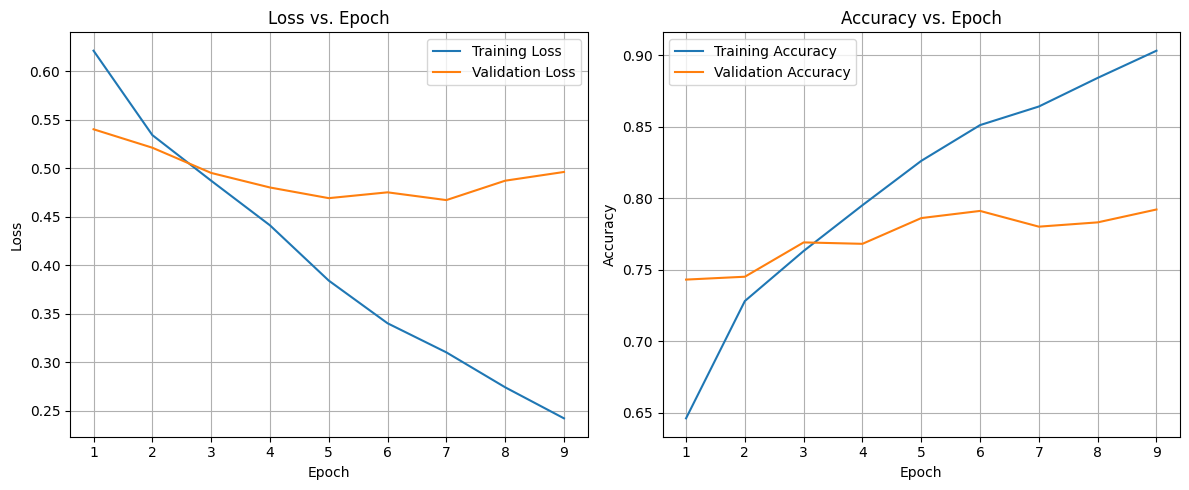

In [174]:
import matplotlib.pyplot as plt

train_losses = [0.621, 0.534, 0.487, 0.441, 0.384, 0.340, 0.310, 0.274, 0.242]
valid_losses = [0.540, 0.521, 0.495, 0.480, 0.469, 0.475, 0.467, 0.487, 0.496]

train_accs = [0.646, 0.728, 0.763, 0.795, 0.826, 0.851, 0.864, 0.884, 0.903]
valid_accs = [0.743, 0.745,0.769,0.768, 0.786, 0.791, 0.780, 0.783, 0.792]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 10), train_losses , label='Training Loss')
plt.plot(range(1, 10), valid_losses , label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(range(1, 10), train_accs , label='Training Accuracy')
plt.plot(range(1, 10), valid_accs , label='Validation Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [42]:
from torchviz import make_dot
import torch

sample_input = torch.randint(0, VOCAB_SIZE, (1, 100)).to('cpu') 
output = model(sample_input)
dot = make_dot(output, params=dict(model.named_parameters()))

dot.format = 'png'  
dot.render('result/cnn_model_graph')


'result\\cnn_model_graph.png'

# Question 3. Enhancement

(d) Report the accuracy scores of CNN on the test set (Part 3.4).          
   78%

### Archive

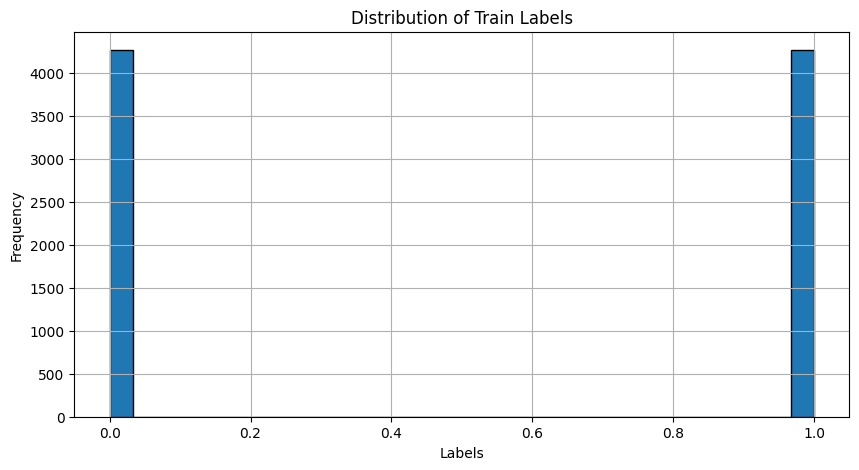

In [9]:
import matplotlib.pyplot as plt

# Plot the distribution for train labels
dataset = load_dataset("rotten_tomatoes")
train_labels = [example['label'] for example in dataset['train']]

plt.figure(figsize=(10, 5))
plt.hist(train_labels, bins=30, edgecolor='black')
plt.title('Distribution of Train Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

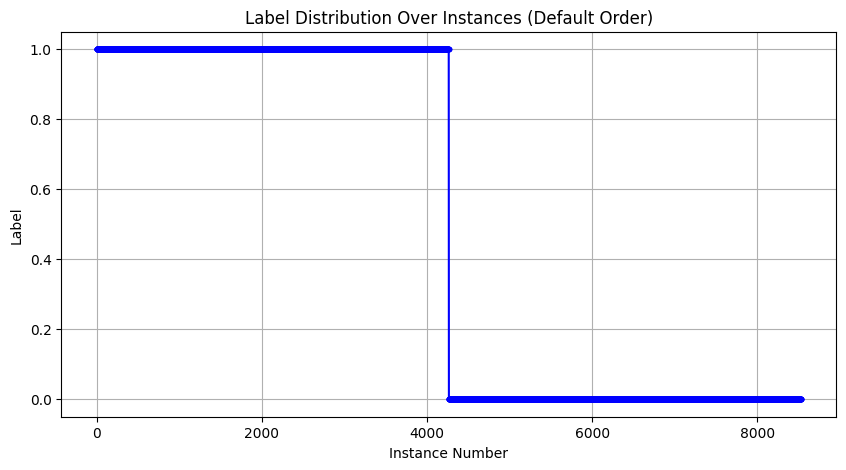

In [10]:
import matplotlib.pyplot as plt

# Plot the distribution for train labels
train_labels = [example['label'] for example in dataset['train']]

# Assuming 'train_labels' is already defined as a list of labels
# Create the x-axis based on the number of labels
x_axis = range(len(train_labels))

plt.figure(figsize=(10, 5))
plt.plot(x_axis, train_labels, marker='o', linestyle='-', color='blue', markersize=3)  # Plot each label with a line
plt.title('Label Distribution Over Instances (Default Order)')
plt.xlabel('Instance Number')
plt.ylabel('Label')
plt.grid(True)
plt.show()

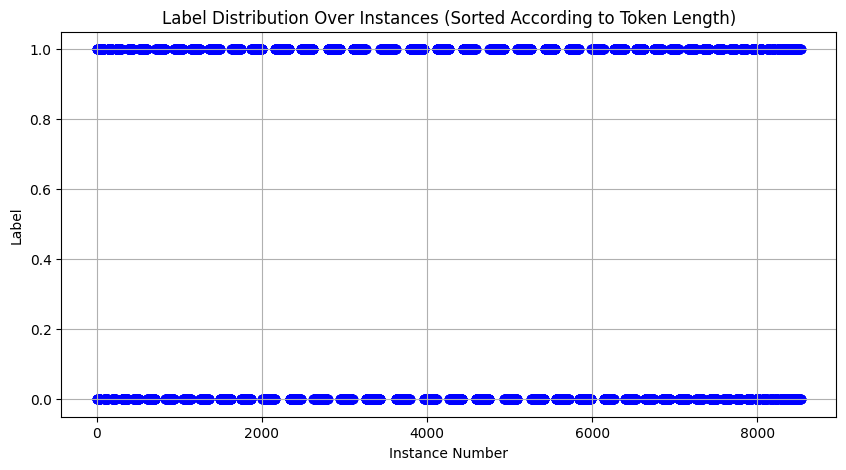

In [11]:
# Step 1: Tokenize the texts
def tokenize_and_get_lengths(texts, word2idx, unk_token, max_len=512):
    lengths = []
    for text in texts:
        tokens = nltk.word_tokenize(text.lower())
        token_ids = [word2idx.get(word, word2idx[unk_token]) for word in tokens]
        token_ids = token_ids[:max_len]  # Truncate to max_len
        lengths.append(len(token_ids))  # Get the length of tokenized sequence
    return lengths

# Step 2: Get lengths of the tokenized sequences in the training set
train_texts = [example['text'] for example in dataset['train']]
train_labels = [example['label'] for example in dataset['train']]

# Tokenize and get the lengths of each text
token_lengths = tokenize_and_get_lengths(train_texts, word2idx, UNK_TOKEN)

# Step 3: Sort the labels based on the token lengths
sorted_indices = sorted(range(len(token_lengths)), key=lambda i: token_lengths[i])
train_labels_sorted = [train_labels[i] for i in sorted_indices]

# Step 4: Plot the sorted labels
x_axis = range(len(train_labels_sorted))

plt.figure(figsize=(10, 5))
plt.scatter(x_axis, train_labels_sorted, marker='o', color='blue')  # Plot each label with a line
plt.title('Label Distribution Over Instances (Sorted According to Token Length)')
plt.xlabel('Instance Number')
plt.ylabel('Label')
plt.grid(True)
plt.show()


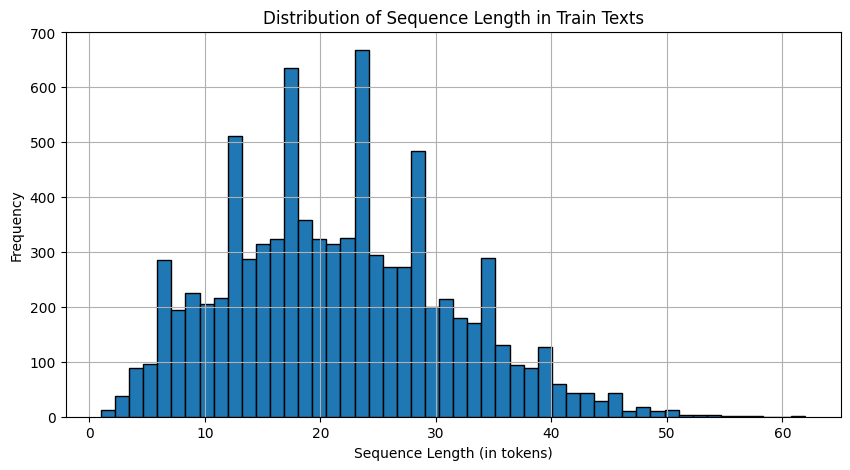

In [12]:
import matplotlib.pyplot as plt
import nltk

def tokenize(texts, word2idx, unk_token, max_len=None):
    """
    Tokenize the given texts and optionally truncate to max length.
    
    :param texts: List of texts to tokenize.
    :param word2idx: Dictionary mapping words to their corresponding IDs.
    :param unk_token: Token to use for unknown words.
    :param max_len: Optional maximum length to truncate each tokenized sequence.
    :return: List of tokenized sequences as lists of token IDs.
    """
    tokenized = []
    for text in texts:
        tokens = nltk.word_tokenize(text.lower())
        token_ids = [word2idx.get(word, word2idx[unk_token]) for word in tokens]
        if max_len:
            token_ids = token_ids[:max_len]  # Truncate to max_len if provided
        tokenized.append(token_ids)
    return tokenized

train_texts = [example['text'] for example in dataset['train']]
train_tokenized = tokenize(train_texts, word2idx, UNK_TOKEN)

# Calculate sequence lengths
sequence_lengths = [len(tokens) for tokens in train_tokenized]

# Plot the distribution of sequence lengths
plt.figure(figsize=(10, 5))
plt.hist(sequence_lengths, bins=50, edgecolor='black')
plt.title('Distribution of Sequence Length in Train Texts')
plt.xlabel('Sequence Length (in tokens)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
